Загрузка самых базовых библиотек:

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [75]:
base = 'data/archive/'

In [76]:
data = pd.read_csv(base + 'organisations.csv')
features = pd.read_csv(base + 'features.csv')
rubrics = pd.read_csv(base + 'rubrics.csv')

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68339 entries, 0 to 68338
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   org_id        68339 non-null  uint64 
 1   city          68339 non-null  object 
 2   average_bill  32778 non-null  float64
 3   rating        54608 non-null  float64
 4   rubrics_id    68339 non-null  object 
 5   features_id   57290 non-null  object 
dtypes: float64(2), object(3), uint64(1)
memory usage: 3.1+ MB


In [78]:
rubrics

,rubric_id,rubric_name
0,30519,"Булочная, пекарня"
1,30770,"Бар, паб"
2,30771,Быстрое питание
3,30774,Кафе
4,30775,Пиццерия
5,30776,Ресторан
6,30777,Столовая
7,31286,Спортбар
8,31350,Кондитерская
9,31375,Суши-бар


In [79]:
rubric_dict = pd.Series(rubrics.rubric_name.values, index = rubrics.rubric_id).to_dict()

In [80]:
rubric_dict

{30519: 'Булочная, пекарня',
 30770: 'Бар, паб',
 30771: 'Быстрое питание',
 30774: 'Кафе',
 30775: 'Пиццерия',
 30776: 'Ресторан',
 30777: 'Столовая',
 31286: 'Спортбар',
 31350: 'Кондитерская',
 31375: 'Суши-бар',
 31401: 'Кальян-бар',
 31495: 'Кофейня',
 3108292683: 'Бар безалкогольных напитков',
 3501514558: 'Фудкорт',
 3501750896: 'Кофе с собой'}

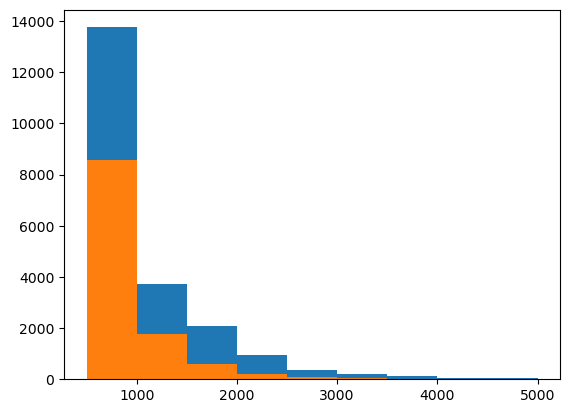

In [81]:
msk = data.set_index('city').loc['msk'].average_bill.values                 #Пиздец, это заняло у меня 30+ минут
sbp = data.set_index('city').loc['spb'].average_bill.values

plt.hist(msk, bins = range(500, 5500, 500))
plt.hist(sbp, bins = range(500, 5500, 500))
plt.show()

**Базовая очистка данных**


С пропусками можно бороться по-разному (даже и с пропусками в таргете), но пока мы сделаем самую простую вещь: дропнем все заведения, для которых мы не знаем средний чек.
Уберите из них все заведения, у которых средний чек неизвестен или превышает 2500. Пока есть опасение, что их слишком мало, чтобы мы смогли обучить на них что-нибудь.

In [82]:
# <Your code here>
for i in data.columns:
    print(i, data[i].value_counts(dropna=False).iloc[0])

org_id 1
city 45619
average_bill 35561
rating 13731
rubrics_id 10116
features_id 11049


In [83]:
filter = data['average_bill'] <= 2500

data = data[filter]

## Формулируем задачу

Прежде, чем решать задачу, её надо сформулировать.

**Вопрос первый**: это классификация или регрессия? Подумайте над этим.

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    Ответ не столь однозначен, как хотелось бы. С одной стороны, таргет принимает всего четыре значения, и потому это может быть классификацией с 4 классами. С другой стороны, таргеты - это не абстрактные "треугольник", "круг", "квадрат", а вещественные числа, и когда мы вместо 500 предсказываем 2500, это явно хуже, чем вместо 1500 предсказать 2000. В целом, задачу можно решать и так, и так; мы будем смотреть на метрики обеих задач.
</details>

**Вопрос второй**: какие метрики мы будем использовать для оценки качества решения? Какие метрики вы предложили бы для этой задачи как для задачи классификации? А для этой задачи, как для задачи регрессии?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
    Начнём с классификации. Метрика accuracy не очень хороша из-за несбалансированности классов. Действительно, классификатор, который всегда говорит 500, будет иметь accuracy примерно 0.66, хотя это никак не отражает практическую ценность модели. Как мы увидим, самая большая проблема будет заключаться в том, чтобы научиться выделять заведения с большими чеками, а их меньше всего и в accuracy они вносят самый маленький вклад. Есть разные способы с этим бороться, один -- использовать sklearn.metrics.balanced_accuracy_score. Его идея, грубо говоря, в том, чтобы по каждому классу найти, какая доля объектов этого класса правильно классифицирована, а потом эти доли усреднить. Тогда у бессмысленного классификатора, который всем ставит 500, будет скор 1/5 (ведь классов 5), а чтобы получить прежние 2/3, нужно будет научиться в каждом классе правильно ставить хотя бы 2/3 меток.    
    
    Теперь что касается регрессии. Основых метрики две - MSE и MAE. Из первой стоит извлекать корень, чтобы получать интерпретируемые человеком значения, а вторая менее агрессивна к выбросам (впрочем, выбросов тут уже нет, мы их все выкинули). Без дополнительной информации не очень понятно, какую выбирать, можно брать любую. А выбирать надо: ведь даже банальные модели "предсказывай всегда среднее" и "предсказывай всегда медиану" будут по-разному ранжироваться этими метриками.
    
</details>

**Вопрос третий**: а не взять ли нам какую-нибудь более экзотическую метрику? Например, MAPE (определение в учебнике в главе про оценку качества моделей). А как вам такое соображение: допустим, заказчик говорит, что пользователи будут расстраиваться, только если мы завысили средний чек - так давайте поправим MSE или MAE, обнуляя те слагаемые, для которых предсказанный таргет меньше истинного. Вот это хорошая метрика или нет?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
    Что касается MAPE, у нас нет тех проблем, с которой она борется. Вот если бы у нас были средние чеки от 500 до миллиона, мы бы столкнулись с ситуацией, что большие ошибки для больших чеков доминировали бы в сумме для MSE и MAE (500 вместо 1000 меркнет по сравнению с 500к вместо миллиона). Говоря поэтически, мы бы оптимизировали модель для миллионеров, забыв про простых трудяг. И было бы логично перейти от парадигмы "ошибаемся на 500 рублей" к парадигме "ошибаемся на 50%". Но у нас все таргеты примерно одного порядка, MAPE нам особо ни к чему.
    
    Вторая метрика коварна тем, что её можно "накрутить" безо всякой пользы для дела. А именно, модель, которая всегда предсказывает средний чек в миллион, была бы идеальна. Но все бы расстраивались и не ходили есть. Другое дело, что можно ввести разные веса для ошибок в большую и в меньшую сторону, но опять же - пока нет показаний к тому, что это нужно.
    
</details>

## Применяем ML

Теперь время разбить данные на обучающую и тестовую выборку. Делается это с помощью функции ``train_test_split`` из пакета ``sklearn``. При этом очень важно сделать две вещи:

* Зафиксировать ``random_state=42`` (да, именно этот, а то ваши модели могут не зайти в Контест), чтобы всё, что мы делаем, было воспроизводимо (иначе от перезапуска к перезапуску числа могут меняться, и мы не будем понимать, из-за чего это происходит).
* Сделать стратификацию по таргету. В противном случае у нас в трейне и тесте могут оказаться разные пропорции классов (обычно особенно страдают мало представленные классы), что неутешительно скажется на результате.

**Обратите внимание**, что если вы побьёте выборку на train и test по-другому, ваши результаты могут не зайти в контест.

In [84]:
clean_data_train, clean_data_test = train_test_split(
    data, stratify=data['average_bill'], test_size=0.33, random_state=42)

Теперь нам нужен **бейзлайн** - очень простая модель, с которой мы в дальнейшем будем сравниваться.

Поскольку мы ещё не знаем никаких умных классов моделей, все модели мы будем писать руками. А именно, мы напишем две простых модели на основе ``sklearn.baseRegressorMixin`` и ``sklearn.base.ClassifierMixin`` (посмотрите примеры в документации sklearn и сделайте так же):

* Модель для задачи регрессии, которая для всех заведений предсказывает одно число — среднее значение среднего чека;
* Модель для задачи классификации, которая для всех заведений предсказывает один класс — самый частый класс (ироничным образом он в данном случае совпадает с медианой).

**Важно!** Мы будем много раз повторять вам мантру о том, что **информация из тестовой выборки не должна протекать в процесс обучения**. Так вот, и среднее, и самый частый класс вы должны считать именно на обучающей выборке!

**5 и 6. Напишите эти две модели и сдайте в Контест**. В процессе проверки модели будут и обучаться, и предсказывать.

Заметим, что для этих моделей нам вообще не нужны какие-то "фичи"; мы работаем только с таргетом.

У каждой модели есть (как минимум) два метода: `fit` (обучает модель по фичам `X` и таргету `y`) `predict` (предсказывает по фичам `X`)

In [85]:
from scipy.stats import mode

from sklearn.base import RegressorMixin

class MeanRegressor(RegressorMixin):
    # Predicts the mean of y_train
    def fit(self, X=None, y=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        self.mean = y.mean()

    def predict(self, X=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return np.full(shape=X.shape[0], fill_value=self.mean)

from sklearn.base import ClassifierMixin

class MostFrequentClassifier(ClassifierMixin):

    def __init__(self, *, param = 1):
        self.param = param
        
    def fit(self, X=None, y=None):
        self.is_fitted_ = True
        
        self.param = mode(y)[0]
        return self

    def predict(self, X=None):
        return np.full(shape=X.shape[0], fill_value = self.param)


Обучим наши модели

In [86]:
reg = MeanRegressor()
reg.fit(y=clean_data_train['average_bill'])

clf = MostFrequentClassifier(param = 1)
clf.fit(y=clean_data_train['average_bill'])

MostFrequentClassifier(param=500.0)

In [87]:
reg.predict(clean_data_test)

array([752.10162092, 752.10162092, 752.10162092, ..., 752.10162092,
       752.10162092, 752.10162092])

In [88]:
mode(data.average_bill)[0]

500.0

In [89]:
clf.predict(clean_data_test)

array([500., 500., 500., ..., 500., 500., 500.])

In [90]:
clf.fit(y = [1,2,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1])

MostFrequentClassifier(param=4)

Обучите модели и оцените их качество на тестовой выборке. В качестве метрик возьмём RMSE (``np.sqrt`` от ``sklearn.metrics.mean_squared_error``) и ``sklearn.metrics.balanced_accuracy_score``.

Для регрессионной модели имеет смысл считать только RMSE (значения будут не кратны 500, точно мы угадывать не будем никогда), а вот для классификационной можно найти обе метрики. Сделайте это. Какая модель оказалась лучше по RMSE?

<details>
  <summary>Когда будете готовы, кликните сюда</summary>
    
  Казалось бы, регрессор никогда не угадывает, но он в каком-то смысле лучше классификатора - справедливо ли это? Возможно. Несуществующий пользователь модели вряд ли будет задавать вопросы "почему средний чек не кратен 500?" Ну, выдали около 800 - ок, понятно.
    
</details>

## Усложнение модели

Бейзлайны будут нашей отправной точкой. Строя дальнейшие модели, мы будем спрашивать себя: получилось ли лучше бейзлайна? Если нет или если не особо, то в чём смысл усложнения?

Начнём с использования фичи ``city``. Мы уже видели, что в разных городах и средние чеки разные. Легко проверить, что *медиана* средних чеков всё же одна и та же и в Москве, и в Санкт-Петербурге (ох уж этот вездесущий средний чек 500!), поэтому с классификатором мы ничего не сделаем. Но вот регрессор можно попробовать починить.

**7. Напишите регрессор, для каждого заведения предсказывающий среднее значение в том же городе (на обучающей выборке, конечно) и сдайте его в Контест**. Вам может помочь то, что булевы `pandas` и `numpy` столбцы можно умножать на численные — в такой ситуации False работает, как ноль, а True как единица.

In [91]:
from sklearn.base import RegressorMixin

class CityMeanRegressor(RegressorMixin):
    def fit(self, X=None, y=None):
        msk = X.city == 'msk'
        spb = X.city == 'spb'
        self.ans = {'msk': y[msk].mean(), 'spb':y[spb].mean()}

    def predict(self, X=None):
        return [self.ans[i] for i in X.city]

In [92]:
cmr = CityMeanRegressor()
cmr.fit(clean_data_train.drop(columns='average_bill'), clean_data_train['average_bill'])

In [93]:
cmr.predict(clean_data_test)

[677.7104465814781,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 677.7104465814781,
 792.6111908177905,
 792.6111908177905,
 677.7104465814781,
 677.7104465814781,
 677.7104465814781,
 792.6111908177905,
 677.7104465814781,
 677.7104465814781,
 677.7104465814781,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 677.7104465814781,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 677.7104465814781,
 792.6111908177905,
 677.7104465814781,
 792.6111908177905,
 677.7104465814781,
 677.7104465814781,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 677.7104465814781,
 677.7104465814781,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 677.7104465814781,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 792.6111908177905,
 677.7104465814781,


In [94]:
data.groupby('city').average_bill.mean()

city
msk    792.887230
spb    676.449662
Name: average_bill, dtype: float64

Обучите регрессор и сравните его по метрике RMSE с бейзлайнами. Получилось ли улучшить метрику?

Лучше стало, но, правда, не очень сильно. В этот момент очень важно не просто радовать руководителя приростом в третьем знаке, но и думать о том, что происходит.

Средний средний чек по Москве равен 793, в Санкт-Петербурге - 676, а в целом - 752 рубля. MSE, увы, не поможет вам ответить на вопрос, стало ли лучше пользователю, если вы ему вместо 752 рублей назвали 793. Здесь вскрывается весьма существенный порок MSE в этой задаче. Дело в том, что наш изначальный таргет делит заведения на некоторые "ценовые категории", и различие в средних чеках 500 и 1000 в самом деле существенно. Наверное, мы хотели бы как раз правильно предсказывать ценовые категории. Но MSE не очень помогает нам об этом судить. Дальше мы ещё подумаем, как это исправить.

В любом случае, несмотря на улучшение метрики, мы пока не можем судить, стало ли по жизни лучше от усложнения модели.

Поручинившись немного, возьмём на вооружение другую идею. Давайте использовать типы заведений!

Но с типами есть некоторая проблема: в столбце ``rubrics_id`` не всегда один идентификатор, часто их несколько, и всего комбинаций довольно много. Чтобы не возиться с малочисленными типами, давайте сольём их в один безликий ``other``.

Итак, добавьте в обучающие и тестовые данные столбец ``modified_rubrics``, в котором будет то же, что и в ``rubrics_id``, если соответствующая комбинация рубрик содержит хотя бы 100 заведений из обучающей (!) выборки, и строка ``other`` в противном случае.

Здесь вам поможет контейнер ``Counter`` из библиотеки ``collections``.

In [95]:
rubrics_change = data.rubrics_id.value_counts()

data = data.assign(modified_rubrics = data.rubrics_id.apply(lambda x: x if rubrics_change[x] >= 100 else 'other'))
data = data.drop(columns = 'rubrics_id')
data

,org_id,city,average_bill,rating,features_id,modified_rubrics
0,15903868628669802651,msk,1500.0,4.270968,3501685156 3501779478 20422 3502045016 3502045...,30776 30774
1,16076540698036998306,msk,500.0,4.375000,1509 1082283206 273469383 10462 11617 35017794...,30771
2,8129364761615040323,msk,500.0,4.000000,10462 11177 11617 11629 1416 1018 11704 11867 ...,31495
3,15262729117594253452,msk,500.0,4.538813,3501618484 2020795524 11629 11617 1018 11704 2...,30776 30770
4,13418544315327784420,msk,500.0,4.409091,11617 10462 11177 1416 11867 3501744275 20282 ...,31495
...,...,...,...,...,...,...
68328,17662684569129497551,spb,1000.0,4.561707,246 3501779478 1018 3501618484 3501481353 3501...,30776
68329,5700899951016592061,msk,1500.0,4.377129,3501773763 10462 1018 246 3501779478 350175479...,31401
68330,4686040819909966338,msk,1500.0,3.666667,10462 1189498238 11629 1416 1415 11741 3501481...,30776
68331,12499715465202129892,msk,1500.0,4.554577,273469383 10462 21247 1509 1416 3501618484 350...,other


In [100]:
df = data.drop(columns = ['org_id', 'features_id'])

In [104]:
unival = df.modified_rubrics.unique()
aboba = {}
for i in unival:
    aboba[i] = df[df.modified_rubrics == i].average_bill.median()
aboba

{'30776 30774': 1000.0,
 '30771': 500.0,
 '31495': 500.0,
 '30776 30770': 1000.0,
 '30776 30771': 500.0,
 'other': 500.0,
 '30777': 500.0,
 '30770': 500.0,
 '30519': 500.0,
 '30519 30774': 500.0,
 '30774 30771': 500.0,
 '30776': 1000.0,
 '30774 30776': 1000.0,
 '30771 30776': 500.0,
 '30775': 500.0,
 '30774 31495': 500.0,
 '30776 30775': 500.0,
 '30774 30770': 500.0,
 '30774': 500.0,
 '31375': 500.0,
 '30776 30771 30774': 500.0,
 '30771 30774': 500.0,
 '31350': 500.0,
 '30770 30776': 1000.0,
 '30776 31375': 500.0,
 '30774 30770 30776': 1000.0,
 '30774 30777': 500.0,
 '3501750896': 500.0,
 '30776 31495': 500.0,
 '30774 30519': 500.0,
 '30774 30776 30771': 500.0,
 '30775 30776': 1000.0,
 '31495 30774': 500.0,
 '30770 30774': 500.0,
 '31401': 1000.0,
 '30777 30774': 500.0,
 '31375 30776': 1000.0,
 '30774 31375': 500.0}

Теперь настало время написать могучий классификатор, который по заведению предсказывает медиану средних чеков среди тех в обучающей выборке, у которых с ним одинаковые `modified_rubrics` и город (вы спросите, почему медиану, а не самый частый -- спишем это на вдохновение; самый частый тоже можно брать - но медиана работает лучше).

**8. Напишите классификатор и сдайте в Контест**.

In [116]:
class RubricCityMedianClassifier(ClassifierMixin):
        
    def fit(self, X=None, y=None):
        self.dickt ={}
        unival = X.modified_rubrics.unique()
        df = X.assign(target = y)
        for i in unival:
            self.dickt[i] = df[df.modified_rubrics == i].target.median()
            

    def predict(self, X=None):
        return X.apply(lambda x: self.dickt[x.modified_rubrics], axis = 1).values

In [117]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='average_bill'), df.average_bill, test_size=0.4)
r = RubricCityMedianClassifier()
r.fit(x_train, y_train)

In [118]:
for i in r.predict(x_test):
    print(i)

500.0
500.0
500.0
500.0
1000.0
500.0
500.0
500.0
500.0
500.0
1000.0
1000.0
500.0
500.0
500.0
500.0
500.0
500.0
1000.0
1000.0
1000.0
500.0
500.0
500.0
500.0
1000.0
1000.0
500.0
500.0
500.0
500.0
1000.0
500.0
1000.0
500.0
1000.0
1000.0
1000.0
1000.0
500.0
500.0
500.0
1000.0
500.0
500.0
1000.0
1000.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
1000.0
500.0
1000.0
1000.0
500.0
1000.0
1000.0
1000.0
500.0
1000.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
1000.0
500.0
1000.0
500.0
500.0
500.0
1000.0
500.0
1000.0
500.0
1000.0
500.0
500.0
500.0
500.0
1000.0
500.0
500.0
500.0
1000.0
500.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
1000.0
500.0
500.0
500.0
500.0
1000.0
500.0
500.0
1000.0
1000.0
500.0
500.0
500.0
500.0
500.0
1000.0
1000.0
500.0
1000.0
500.0
1000.0
500.0
500.0
500.0
500.0
1000.0
500.0
500.0
1000.0
500.0
500.0
1000.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
1000.0
500.0
500.0
1000.0
1000.0
1000.0
500.0


In [119]:
r.score(x_test, y_test)

0.6960715674834694

Сравните обученный классификатор по метрикам RMSE и balanced_accuracy_score с нашими бейзлайнами. Получилось ли улучшить?

Обратите внимание что рост accuracy по сравнению с бейзлайном при этом на порядок меньше:

accuracy_score

Predict most frequent:  0.6947666195190948

Predict by rubric and city:  0.7095709570957096

Для диагностики напечатайте для каждого класса тестовой выборки, сколько в нём объектов и скольким из них наш классификатор приписал правильный класс. Что вы видите?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
  Вы, вероятно, видите то, что мы стали однозначно лучше по сравнению с бейзлайном детектировать средний чек 1000 и 1500 (хотя всё равно не очень хорошо + ценой ухудшения качества на среднем чеке 500), а вот чеки 2000 и 2500 нам ну никак не даются.
    
</details>

**Кстати**. А вы понимаете, почему приведённый выше пайплайн классификации был не очень удачным с точки зрения архитектуры? Почему его было бы правильнее воплотить по-другому?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
Собственно говоря, и не было никакого пайплайна. К счастью, у нас была одна обучающая выборка, мы на ней посчитали список рубрик для modified_rubrics и радовались жизни. Но если бы нам надо было переобучать всё на новых данных, пришлось бы помнить, что их надо везде пересчитать (ведь у нас могли появиться новые рубрики с хотя бы 100 представителями). А уж никакую кросс-валидацию (кто знает - тот поймёт) с нашим подходом к делу и вовсе бы не получилось сделать без боли.
    
Поэтому в следующей лабораторной вы научитесь делать честные пайплайны, в которых преобразование данных, генерация фичей и обучение классификатора будут объединены в один понятный процесс, происходящий на этапе fit.
</details>

## Слишком простые и слишком сложные модели

Бейзлайны у нас слишком просты и потому не очень полезны в жизни. Но если сложность модели растёт бесконтрольно, то тоже получается плохо.

Давайте рассмотрим конкретный пример. Создадим классификатор, использующий одновременно `rubrics_id` и `features_id`.

Сделайте следующее:

- для каждого объекта обучающей выборки сконкатенируйте строку `rubrics_id` с разделителем (например, буквой 'q') и содержимым `features_id`. Полученный столбец озаглавьте `modified_features`. Это не самый клёвый способ заиспользовать все фичи, но сейчас пока сойдёт. Причём на сей раз не будем выкидывать мало представленные значения (вся информация важна, не так ли?).
- при этом для тестовой выборке заменяйте на строку `other` все конкатенации, которые не встретились в обучающей выборке.

То есть элементы в этом столбце будут иметь вид `other` или `30776 30774 q 3502045032 11741 3502045016 1046...`.

Теперь обучите классификатор, который для заведения предсказывает медиану среднего чека по всем объектам тестовой выборки с таким же, как у него, значением `modified_features`, а если такого в обучающей выборке нет, то глобальную медиану среднего чека по всей обучающей выборке.

**9. Загрузите в Контест предсказания этого классификатора на тестовой выборке**

Мы ждём файла **.csv**, у которого в каждой строке будет только одно число - предсказание классификатора.

Возможно, вам будет полезна библиотека ``tqdm``, позволяющая отслеживать в реальном времени, сколько времени уже крутится цикл и сколько итераций ещё осталось. Впрочем, если вы всё написали нормально, то должно работать не очень долго.

Модель, очевидно, очень сложная. Число параметров (различных категорий) в ней сопоставимо с числом объектов в обучающей выборке. А получилось ли хорошо?

Давайте посчитаем RMSE и balanced_accuracy_score на обучающей и на тестовой выборках.

**10. Введите их в Контест**

Налицо переобучение: на трейне метрики отличные, на тесте - вообще никакие

В общем, не гонитесь за чрезмерной сложностью модели..

## ML без данных что компутер без электричества

Возможно, вы смотрите на полученные выше результаты и думаете: вот если бы мы не какие-то убогие медианы предсказывали, а гоняли бы нейросети, то тут-то бы всё и получилось!

Но, увы, совсем даже не всегда от счастья нас отделяет выбор хорошей модели (и стратегии обучения). Если данные не очень, то даже самая крутая модель не сработает. В этой ситуации нужно либо добывать новые фичи каким-то образом, либо собирать новые данные (увеличивать датасет), либо просто бросать задачу.

Давайте посмотрим, что выжмет из наших данных одна из самых мощных моделей для табличных данных - градиентный бустинг на решающих деревьях в исполнении [CatBoost](https://catboost.ai/).

Но прежде, чем сделать fit, нам надо облагородить данные. Несмотря на то, что CatBoost отлично работает с категориальными фичами, мешок признаков из `rubrics_id` или `features_id` может ему оказаться не по зубам. Поэтому мы соберём датасет в пристойную матрицу, создав для каждого типа рубрик и фичей отдельный столбец и записав там единицы для тех объектов, у которых эта рубрика или фича имеет место.

В матрице почти все элементы будут нулями. Такие матрицы считаются **разреженными** и их можно хранить гораздо эффективней, чем просто таблицей. Этим и займёмся)

Есть несколько форматов хранения разреженных матриц (многие из них реализованы в [пакете sparse библиотеки scipy](https://docs.scipy.org/doc/scipy/reference/sparse.html)), и каждый пригоден для чего-то своего.

Создавать разреженную матрицу лучше в [формате COO](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array). Он предполагает, что разреженная матрица задаётся в виде трёх списков: `row`, `col`, `data`, причём каждая тройка `(row[i], col[i], data[i])` кодирует элемент со значением `data[i]`, стоящий на позиции `(row[i], col[i])`. Считается, что на позициях `(row, col)`, которые ни разу не встретились, стоят нули.

Нетрудно видеть, что заполнять такую матрицу - одно удовольствие, и особенно этому помогает тот факт, что **пара `(row, col)` может встретиться несколько раз** (тогда в итоговой матрице на соответствующей позиции стоит сумма соответствующих `data[i]`). Но, с другой стороны, почти ничего другого с такой матрицей не сделаешь: произвольного доступа к элементам она не предоставляет, умножить её тоже особо ничего не умножишь. Поэтому для дальнейшего использования созданную таким образом матрицу преобразуют в один из более удобных форматов, например, [CSR (compressed sparse row)](https://scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html). Он, к примеру, хорошо подходит для умножения на вектор (потому что матрица хранится по строкам). Не будем разбирать его подробно, но можете почитать по ссылке, если интересно.

Вам нужно будет превратить обучающие и тестовые данные в разреженные матрицы `sparse_data_train` и `sparse_data_test` соответственно, таким образом, что:

- столбец `city` превратится в столбец из единиц и нулей (например, 1 - Москва, 0 - Питер);
- столбец `rating` перекочует в разреженные матрицы без изменений;
- каждый типы рубрик и каждая фича превратятся в отдельный 0-1-принак;

В тестовой выборке будут фичи, которых в обучающей выборке не было. С ними можно по-разному работать, но давайте создадим дополнительную фантомную фичу `feature_other`, в которой будет то, сколько неизвестных по обучающей выборке фичей есть у данного объекта.

In [97]:
# <Your code here>

Данные готовы, и теперь можно запустить катбуст

In [98]:
from catboost import CatBoostClassifier

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# <USE IT!>
clf = CatBoostClassifier()
clf.fit(sparse_data_train, clean_data_train['average_bill'])

**11. Пришлите в Контест balanced_accuracy_score на тестовой выборке, округлённый до двух знаков после запятой**. Стало ли сильно лучше от того, что мы воспользовались таким крутым классификатором?